## Data Exploration

#### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.preprocessing import OneHotEncoder

sns.set_style('ticks')
sns.set_palette('pastel')
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### Read Data

In [2]:
movies = pd.read_csv('../data/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='ISO-8859-1')
ratings = pd.read_csv('../data/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='ISO-8859-1')
users = pd.read_csv('../data/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], encoding='ISO-8859-1')

#### Shape and Info of Data

In [3]:
print("Ratings dataset shape:", ratings.shape)
print("Users dataset shape:", users.shape)
print("Movies dataset shape:", movies.shape)

print("Ratings dataset info:")
print(ratings.info())

print("Users dataset info:")
print(users.info())

print("Movies dataset info:")
print(movies.info())

Ratings dataset shape: (1000209, 4)
Users dataset shape: (6040, 5)
Movies dataset shape: (3883, 3)
Ratings dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None
Users dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None
Movies dataset info:

In [4]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


- Titles are identical to titles provided by the IMDB (including year of release)
- Genres are pipe-separated
    - We need to split this to allow for easy analysis

In [5]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
    - We will need to convert this to a datetime format
- Each user has at least 20 ratings

In [6]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from specific ranges
    - We will convert them into groups for easier analysis
- Occupation needs to be mapped to the names provided in the README


## Feature Engineering

In [7]:
# One-hot encoding for genres
genres = movies['genres'].str.get_dummies('|')
df = pd.concat([movies, genres],axis=1).merge(ratings,how='left',on='movie_id').drop(columns={'genres'})

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['timestamp'].describe()

count                 1000209
unique                 458455
top       2000-11-29 20:06:42
freq                       30
first     2000-04-25 23:05:32
last      2003-02-28 17:49:50
Name: timestamp, dtype: object

In [8]:
# Create age groups
bins = [0, 18, 25, 35, 45, 50, 56, np.inf]
ages = ['<18', '18-24', '24-34','35-44', '45-49', '50-55', '56+']
users['age_group'] = pd.cut(users['age'], bins, labels=ages)
users = users.drop(["age"], axis = 1)

occupation_map = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# Map the occupation IDs to occupation names in the users dataframe
users['occupation'] = users['occupation'].map(occupation_map)

users.head()

,user_id,gender,occupation,zip_code,age_group
0,1,F,K-12 student,48067,<18
1,2,M,self-employed,70072,50-55
2,3,M,scientist,55117,18-24
3,4,M,executive/managerial,02460,35-44
4,5,M,writer,55455,18-24


In [9]:
# merge users with df
df = df.merge(users, how='left', on='user_id')

# create year-month column 
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

df.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating,timestamp,gender,occupation,zip_code,age_group,year_month
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,5.0,2001-01-06 23:37:48,F,K-12 student,48067,<18,2001-01
1,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,4.0,2000-12-31 04:30:08,F,homemaker,55117,45-49,2000-12
2,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0,4.0,2000-12-31 03:31:36,M,programmer,11413,18-24,2000-12
3,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0,5.0,2000-12-31 01:25:52,M,technician/engineer,61614,18-24,2000-12
4,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,5.0,2000-12-31 01:34:34,F,academic/educator,95370,24-34,2000-12


In [10]:
# Remove missing values
df = df[(~df['rating'].isna()) & (~df['user_id'].isna()) & (~df['timestamp'].isna())]
df.isnull().sum()

movie_id       0
title          0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
user_id        0
rating         0
timestamp      0
gender         0
occupation     0
zip_code       0
age_group      0
year_month     0
dtype: int64

In [11]:
# Convert user_id, movie_id, rating to string
df['user_id'] = df['user_id'].astype(int).astype(str)
df['rating'] = df['rating'].astype(int).astype(str)
df['movie_id'] = df['movie_id'].astype(int).astype(str)
df['rating'] = df['rating'].astype(int)
df['gender'] = df['gender'].astype('category')
df['occupation'] = df['occupation'].astype('category')
df['age_group'] = df['age_group'].astype('category')

#### Final Dataframe for Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000385
Data columns (total 28 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   movie_id     1000209 non-null  object        
 1   title        1000209 non-null  object        
 2   Action       1000209 non-null  int64         
 3   Adventure    1000209 non-null  int64         
 4   Animation    1000209 non-null  int64         
 5   Children's   1000209 non-null  int64         
 6   Comedy       1000209 non-null  int64         
 7   Crime        1000209 non-null  int64         
 8   Documentary  1000209 non-null  int64         
 9   Drama        1000209 non-null  int64         
 10  Fantasy      1000209 non-null  int64         
 11  Film-Noir    1000209 non-null  int64         
 12  Horror       1000209 non-null  int64         
 13  Musical      1000209 non-null  int64         
 14  Mystery      1000209 non-null  int64         
 15  Romance      10

In [13]:
df.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating,timestamp,gender,occupation,zip_code,age_group,year_month
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,2001-01-06 23:37:48,F,K-12 student,48067,<18,2001-01
1,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,4,2000-12-31 04:30:08,F,homemaker,55117,45-49,2000-12
2,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,2000-12-31 03:31:36,M,programmer,11413,18-24,2000-12
3,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9,5,2000-12-31 01:25:52,M,technician/engineer,61614,18-24,2000-12
4,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10,5,2000-12-31 01:34:34,F,academic/educator,95370,24-34,2000-12


## Data Visualizations

#### Ratings Distribution

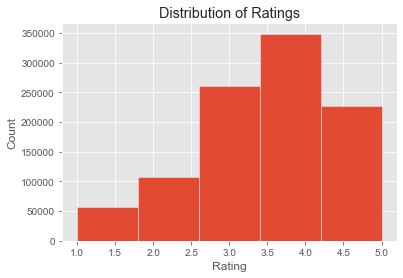

In [14]:
# Plot distribution of ratings
plt.hist(df['rating'], bins=5)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

#### Gender Distribution

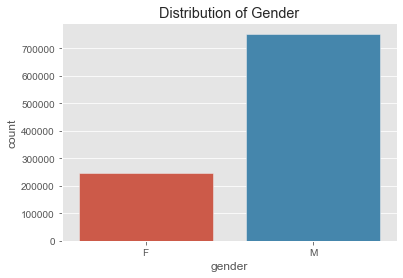

In [15]:
# Plot distribution of gender
sns.countplot(x='gender', data=df)
plt.title("Distribution of Gender")
plt.show()

#### Age Distribution

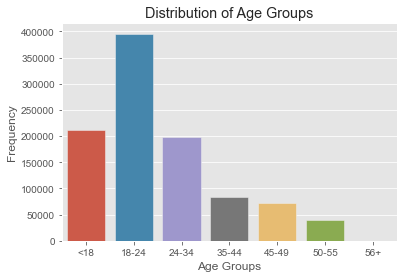

In [16]:
# Plot distribution of age groups
sns.countplot(x='age_group', data=df)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Frequency')
plt.show()

#### Occupation Distribution

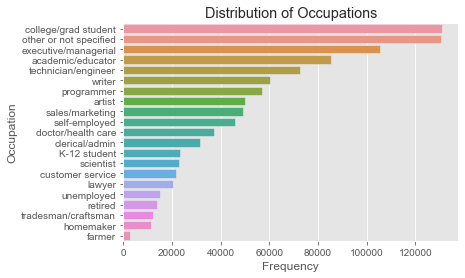

In [17]:
# Plot distribution of occupations, ordered by count
sns.countplot(y='occupation', data=df, order=df['occupation'].value_counts().index)
plt.title('Distribution of Occupations')
plt.xlabel('Frequency')
plt.ylabel('Occupation')
plt.show()

#### Top Movies

In [18]:
# Rank top 10 movies by weighted rating scores, where k refers to the weight of the rating
def weighted_average_score(df, k=0.7):
    n_views = df.groupby('movie_id', sort=False).movie_id.count()
    ratings = df.groupby('movie_id', sort=False).rating.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('movie_id', sort=False).agg({'title':'first', 
                                                         'rating':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

weighted_average_score(df).head(10)

,title,rating,views
movie_id,,,
2858,American Beauty (1999),4.317386,3428
260,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
1196,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
1198,Raiders of the Lost Ark (1981),4.477725,2514
2028,Saving Private Ryan (1998),4.337354,2653
593,"Silence of the Lambs, The (1991)",4.351823,2578
527,Schindler's List (1993),4.510417,2304
318,"Shawshank Redemption, The (1994)",4.554558,2227
2762,"Sixth Sense, The (1999)",4.406263,2459


##### Movie Views by Genre

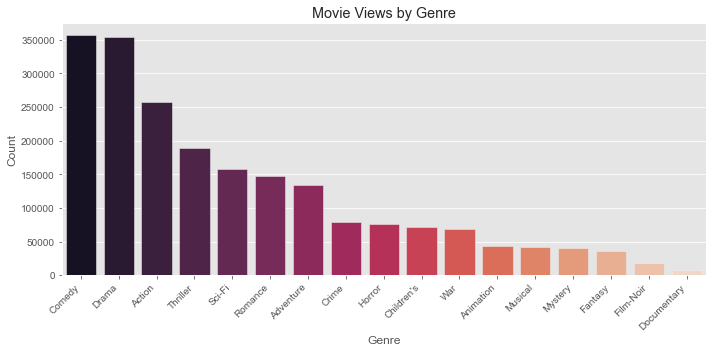

In [19]:
# Plot of movie views by genre
genre_counts = df.iloc[:, 2:19].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="rocket")
ax.set(xlabel='Genre', ylabel='Count', title='Movie Views by Genre')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

It's not an even distribution as Comedy and Drama are clearly the most popular genre in this dataset. Genres like Documentary and Film-Noir are seldom watched and there's a significant difference between them and the top genres.

#### Average rating by Categorical Variables

##### Genre Raings

In [20]:
# Unpivot the genre columns
melted_df = df.melt(id_vars=['movie_id', 'title', 'rating', 'user_id', 'age_group', 'gender', 'occupation', 'zip_code', 'year_month', 'timestamp'], var_name='genre', value_name='has_genre')
# Filter out rows where has_genre is 0
melted_df = melted_df[melted_df['has_genre'] == 1]
melted_df['rating'] = melted_df['rating'].astype(int)
# Table of average ratings by genre
average_ratings_genres = melted_df.groupby('genre')['rating'].mean().sort_values(ascending=False)
average_ratings_genres

genre
Film-Noir      4.075188
Documentary    3.933123
War            3.893327
Drama          3.766332
Crime          3.708679
Animation      3.684868
Mystery        3.668102
Musical        3.665519
Western        3.637770
Romance        3.607465
Thriller       3.570466
Comedy         3.522099
Action         3.491185
Adventure      3.477257
Sci-Fi         3.466521
Fantasy        3.447371
Children's     3.422035
Horror         3.215013
Name: rating, dtype: float64

##### Gender Raings

In [21]:
df.groupby('gender')['rating'].mean()

gender
F    3.620366
M    3.568879
Name: rating, dtype: float64

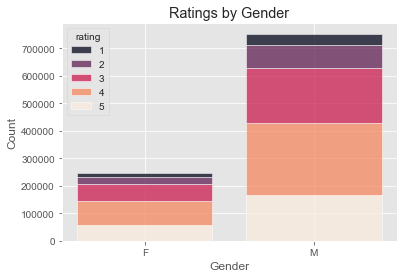

In [22]:
# Plot of ratings count by age group
sns.histplot(data=df, x='gender', hue='rating', multiple='stack', shrink=.8, palette='rocket', edgecolor='white', linewidth=.5)
plt.title('Ratings by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

##### Age Group Raings

In [23]:
df.groupby('age_group')['rating'].mean()

age_group
<18      3.512990
18-24    3.545235
24-34    3.618162
35-44    3.638062
45-49    3.714512
50-55    3.766632
56+           NaN
Name: rating, dtype: float64

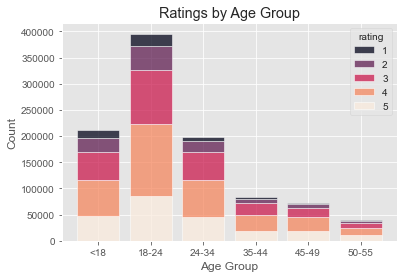

In [24]:
# Plot of ratings count by age group
sns.histplot(data=df, x="age_group", hue="rating", multiple="stack", shrink=.8, palette='rocket', edgecolor='white', linewidth=.5)
plt.title("Ratings by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

##### Occupation Raings

In [25]:
df.groupby('occupation')['rating'].mean()

occupation
K-12 student              3.532675
academic/educator         3.576642
artist                    3.573081
clerical/admin            3.656516
college/grad student      3.536793
customer service          3.537529
doctor/health care        3.661578
executive/managerial      3.599772
farmer                    3.466741
homemaker                 3.656589
lawyer                    3.617371
other or not specified    3.537544
programmer                3.654001
retired                   3.781736
sales/marketing           3.618481
scientist                 3.689774
self-employed             3.596575
technician/engineer       3.613574
tradesman/craftsman       3.530117
unemployed                3.414050
writer                    3.497392
Name: rating, dtype: float64

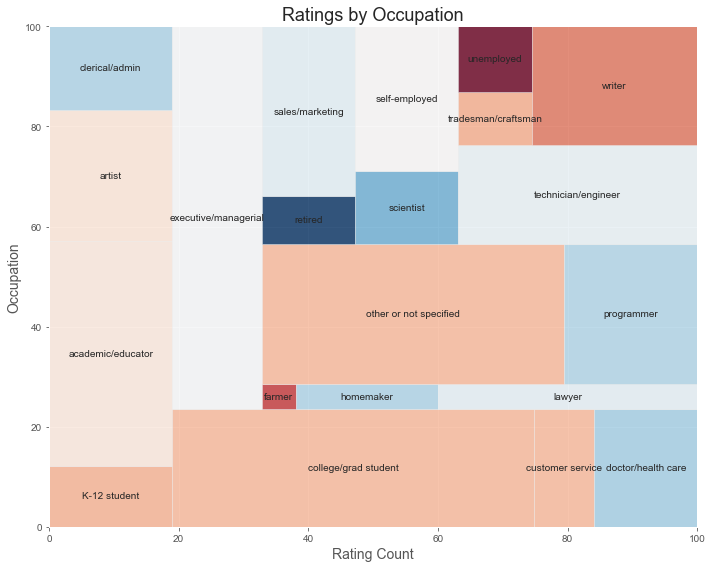

In [26]:
# Group by occupation and calculate mean rating and rating count
occupation_agg = df.groupby('occupation').agg({'rating': ['mean', 'count']})
occupation_agg.columns = ['mean_rating', 'rating_count']
occupation_agg = occupation_agg.reset_index()

# Define color palette
cmap = plt.cm.RdBu
mini, maxi = occupation_agg['mean_rating'].min(), occupation_agg['mean_rating'].max()
norm = plt.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in occupation_agg['mean_rating']]

# Set up plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot treemap
squarify.plot(sizes=occupation_agg['rating_count'], label=occupation_agg['occupation'], alpha=0.8, color=colors)

# Add title and axis labels
plt.title('Ratings by Occupation', fontsize=18)
plt.xlabel('Rating Count', fontsize=14)
plt.ylabel('Occupation', fontsize=14)

# Adjust font sizes
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.tight_layout()

# Show plot
plt.show()

#### Rating over Time

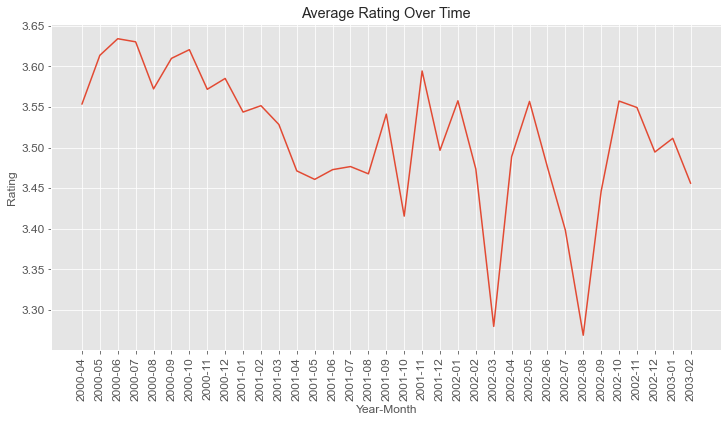

In [28]:
# Group the data by year_month and calculate the mean rating
avg_rating = df.groupby(['year_month'], as_index=False)['rating'].mean()

plt.figure(figsize=(12,6))

# Plot the line chart using seaborn
sns.lineplot(x='year_month', y='rating', data=avg_rating)

# Set the plot title and axis labels
plt.title('Average Rating Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Rating')
plt.xticks(rotation=90)

# Show the plot
plt.show()

#### Correlation Plot

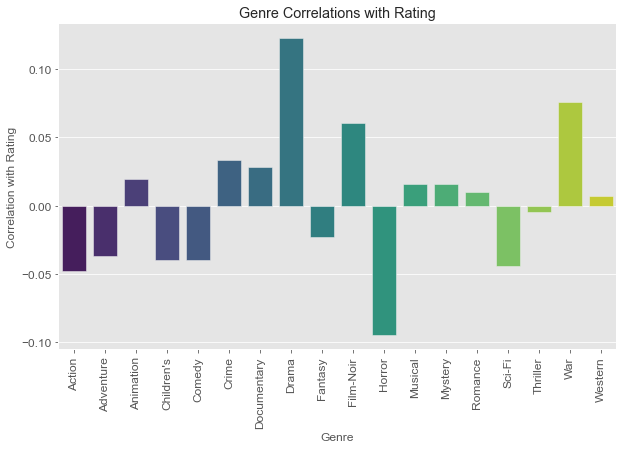

In [29]:
# calculate the correlation between each genre and the rating column
genre_corr = df.iloc[:, 2:20].corrwith(df['rating'])

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_corr.index, y=genre_corr.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Correlation with Rating')
plt.title('Genre Correlations with Rating')
plt.show()

### Dataframes for bandit algorithms

In [30]:
movie_features = df[['movie_id', 'Action', 'Adventure', 'Animation', "Children's",
                     'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                     'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

movie_features.head()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# Generate user features as a sparse matrix
columnsToEncode = ['age_group','gender','occupation']
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(users[columnsToEncode])

user_features = pd.concat([users.drop(columnsToEncode, 1), 
                           pd.DataFrame(myEncoder.transform(users[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names_out(columnsToEncode))], axis=1).reindex()

user_features.head()

,user_id,zip_code,age_group_18-24,age_group_24-34,age_group_35-44,age_group_45-49,age_group_50-55,age_group_<18,gender_F,gender_M,occupation_K-12 student,occupation_academic/educator,occupation_artist,occupation_clerical/admin,occupation_college/grad student,occupation_customer service,occupation_doctor/health care,occupation_executive/managerial,occupation_farmer,occupation_homemaker,occupation_lawyer,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer
0,1,48067,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,70072,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,55117,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,02460,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,55455,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
